**Rio de Janeiro, 24 de Abril de 2016**

Aluno: **Carlos Mattoso**

Matrícula: **1210553**

Disciplina: **INF1335 - Introdução a Data Science com R e Python**

# A1 - Dengue e Renda

## Introdução

O trabalho abaixo apresenta duas análises da associação entre taxa de incidência de dengue e renda domiciliar por Unidade Federativa (UF). A primeira análise é feita com base em dados pré-processados da PNAD Contínua de renda domiciliar per capita publicados pelo datasus [2]. A segunda análise é feita com base nos microdados disponibilizados pelo IBGE [1], tendo sido a entregue na primeira entrega deste trabalho.

## Setup

Primeiramente, é necessário que sejam baixados todos os _datasets_ necessários para as análises e instaladas as bibliotecas que serão utilizadas. Rode o código abaixo para que o ambiente seja preparado por você. Caso você já tenha os anos baixados em disco, cada um em seu próprio sub-diretório com nome igual ao do ano, basta redefinir o valor de `base.dir` antes de executar o código abaixo.

In [1]:
# ---------------------------------------------------------------------------------------------------------------------
# SETUP Base
# ---------------------------------------------------------------------------------------------------------------------
printf <- function(...) invisible(print(sprintf(...))) # source: http://stackoverflow.com/a/13023329
    
DEBUG = T
if (!DEBUG) { 
    noW <- function(...) invisible(suppressWarnings(...))
} else {
    noW <- function(...) invisible(...)
}

# Handy function to load RData files into object.
load.rdata.into.obj <- function(input) {
  env <- new.env()
  nm <- load(input, env)[1]
  env[[nm]]
}

# Necessário devido ao encoding dos arquivos SAS
options(encoding = "windows-1252");

# Cria o diretório em que os datasets serão armazenados
base.dir = './data' # !! Mude aqui se já tiver tudo baixado
if (!dir.exists(base.dir)) {
    dir.create(base.dir)
}
    
# Baixa CSV de incidência de dengue por UF do github da disciplina
dengue.url = 'https://raw.githubusercontent.com/simonedjb/inf1335/master/dados/dengueUF.csv'
download.file(dengue.url, destfile=paste(base.dir, 'dengueUF.csv', sep='/'), method='curl')
        
# já produz algumas variáveis úteis

# ---------------------------------------------------------------------------------------------------------------------
# SETUP PARA ANÁLISE 1
# ---------------------------------------------------------------------------------------------------------------------
    
# Baixa o arquivo do datasus com a renda média domiciliar anual per capita já pré-processada
url.datasus = 'https://gist.githubusercontent.com/calmattoso/7d3ffa79bf7b5c9a530a1749180ecf42/raw/b3b6c95e9878d9be1ce7cf394fb5a85cce393929/datasus_2001_2008.csv'
datasus.file.path = paste(base.dir, 'pnad_renda_datasus_2001_2008.csv', sep='/')
if (!file.exists(datasus.file.path)) {
    temp <- tempfile()
    download.file(url.datasus, destfile=temp, method='curl')
    # Abre o csv e faz um rápido pré-processamento para eliminar colunas e linhas desnecessárias
    datasus.csv <- read.csv(temp, sep=';', skip=3, fileEncoding='utf-8')
    datasus.cols <- names(datasus.csv)
    datasus.csv <- datasus.csv[, !(datasus.cols %in% grep("Informa", datasus.cols, value=T)), drop=F] # remove colunas de infos estatísticas
    datasus.csv <- datasus.csv[1:28,] # remove linhas desnecessárias no final do arquivo
    write.csv(datasus.csv, file=datasus.file.path, row.names=F, fileEncoding='utf-8')
    unlink(temp)
} else {
    printf("Arquivo de renda do Datasus já existe!")
}

# ---------------------------------------------------------------------------------------------------------------------
# SETUP PARA ANÁLISE 2
# ---------------------------------------------------------------------------------------------------------------------
    
# Biblioteca para leitura de arquivos SAS
if (!require('SAScii')) {
  install.packages('SAScii', repos="http://cran.rstudio.com/") 
}
library('SAScii')
    
years = 2001:2008
base.url = "ftp://ftp.ibge.gov.br/Trabalho_e_Rendimento/Pesquisa_Nacional_por_Amostra_de_Domicilios_anual/microdados/reponderacao_2001_2012/";
for (year in years) {
    extra = ''
    if (year == 2003 || year == 2007) {
        extra = '_20150814' # isto pq os arquivos de 2003 e 2007 foram atualizados em 14/08/2015
    }
    file.name = paste("PNAD_reponderado_", year, extra, '.zip', sep='')
    url = paste(base.url, file.name, sep='')
    
    # Baixa e descompacta o arquivo do ano caso não já exista a pasta do ano
    if (!dir.exists(paste(base.dir, year, sep='/'))) {
        temp <- tempfile()
        download.file(url, destfile = temp, method='curl')
        unzip(temp,  exdir = base.dir)
        unlink(temp) # deleta o .zip
    } else {
        printf('Dados já existentes pro ano %d.', year)
    }
    
    # Renomeia os arquivos da sub-pasta `Input` segundo um formato comum
    input.files = list.files(paste('data', year, 'Input', sep='/'), full.names=T)
    input.files.ren = gsub('_', ' ', tolower(input.files))
    file.rename(input.files, input.files.ren)
}

[1] "Arquivo de renda do Datasus já existe!"


Loading required package: SAScii


[1] "Dados já existentes pro ano 2001."
[1] "Dados já existentes pro ano 2002."
[1] "Dados já existentes pro ano 2003."
[1] "Dados já existentes pro ano 2004."
[1] "Dados já existentes pro ano 2005."
[1] "Dados já existentes pro ano 2006."
[1] "Dados já existentes pro ano 2007."
[1] "Dados já existentes pro ano 2008."


## Item 1

Acho que seria interessante avaliar a associação para dado ano entre gastos em políticas públicas destinadas ao combate a dengue e a incidência da dengue em determinada UF. Se possível, creio que fazer esta análise a nível de município seria ainda mais útil, já que estaríamos atacando um problema menor. Além disso, seria válido avaliar investimentos gerais em saneamento básico e se isto estaria relacionado com quedas na incidência da dengue, já que é senso comum que a disseminação do mosquito se deve em grande parte ao descaso com o tratamento de resíduos, levando ao acúmulo de água.

## Item 2

### Análise Nova - _Dataset_ da PNADc pré-processado

Esta análise utiliza um _dataset_ pré-processado da PNADc que apresenta os dados de renda anual domiciliar per capita por UF para o período de 2001 a 2008, extraído na plataforma TABNET do DataSUS [3]. Na seção de _Setup_ deste _notebook_ tal _dataset_ já foi baixado e parcialmente pré-processado para estar formatado de maneira a facilitar a análise. Abaixo, exibe-se seu conteúdo:

In [2]:
datasus.csv <- read.csv(datasus.file.path, dec=",", fileEncoding="utf-8")

datasus.csv

,Unidade.da.Federação,X2001,X2002,X2003,X2004,X2005,X2006,X2007,X2008
1,Rondônia,513.04,551.3,482.18,501.13,531.55,578.56,539.47,573.7
2,Acre,618.51,603.7,504.81,405.38,422.79,510.85,529.08,520.71
3,Amazonas,439.19,417.79,397.31,389.29,421.36,440.01,444.1,475.56
4,Roraima,473.38,409.74,448.92,328.37,381.98,524.53,464.19,562.05
5,Pará,413.99,431.97,361.52,380.09,375.02,404.09,441.66,457.6
6,Amapá,540.96,445.1,466.59,395.07,491.78,473.23,500.64,480.35
7,Tocantins,412.81,369.52,385.99,422.79,423.24,462.42,504.69,575.05
8,Maranhão,273.38,275.78,268.36,295.77,263.43,356.22,350.87,360.99
9,Piauí,303.32,324.55,294.96,316.87,333.13,394.2,437.89,446.98
10,Ceará,338.77,332.68,304.49,326.23,351.24,373.8,388.86,436.99


Obtém-se agora os dados da dengue e são feitos pequenos ajustes ao `data frame` de renda:

In [13]:
years.under.analysis = 2001:2008

names(datasus.csv) <- c('UF', years.under.analysis)
datasus.csv <- datasus.csv[1:27,]

dengue = read.csv(paste(base.dir, '/dengueUF.csv', sep=''), dec=",", na.strings = '-')
dengue.cols = sapply('X', paste, years.under.analysis, sep='', USE.NAMES = FALSE)
dengue.subset = dengue[1:27, dengue.cols]

dengue.new.cols = vector(mode="character", length =length(dengue.cols))
for (i in 1:length(names(dengue.subset))) {
    dengue.new.cols[i] = substr(names(dengue.subset)[i], 2, 5)
}
names(dengue.subset) = dengue.new.cols
row.names(dengue.subset) = dengue$UF[1:27]
datasus.csv$UF = dengue$UF[1:27]

datasus.csv

,2001,2002,2003,2004,2005,2006,2007,2008
Rondonia,120.06,109.44,206.68,224.87,387.46,272.33,212.64,365.9
Acre,354.98,151.97,161.51,727.66,345.53,39.61,75.06,313.64
Amazonas,662.66,75.8,132.36,29.02,31.49,19.33,61.37,222.77
Roraima,1140.53,351.14,1390.14,153.2,602.84,251.89,212.15,1207.9
Para,264.13,178.29,148.35,84.63,118.35,92.46,199.51,207.57
Amapa,642.17,166.11,755.37,458,430.55,300.3,562,194.89
Tocantins,417.55,163.88,153.23,120.26,257.17,445.8,949.38,778.75
Maranhao,109.7,146.49,99.75,27.02,108.3,83.61,213.56,87.94
Piaui,359.11,304.88,325.1,29.39,150.65,158.35,315.19,74.81
Ceara,451.71,257.04,429.55,50.08,335.9,346.33,414.13,576.56


,UF,2001,2002,2003,2004,2005,2006,2007,2008
1,Rondonia,513.04,551.3,482.18,501.13,531.55,578.56,539.47,573.7
2,Acre,618.51,603.7,504.81,405.38,422.79,510.85,529.08,520.71
3,Amazonas,439.19,417.79,397.31,389.29,421.36,440.01,444.1,475.56
4,Roraima,473.38,409.74,448.92,328.37,381.98,524.53,464.19,562.05
5,Para,413.99,431.97,361.52,380.09,375.02,404.09,441.66,457.6
6,Amapa,540.96,445.1,466.59,395.07,491.78,473.23,500.64,480.35
7,Tocantins,412.81,369.52,385.99,422.79,423.24,462.42,504.69,575.05
8,Maranhao,273.38,275.78,268.36,295.77,263.43,356.22,350.87,360.99
9,Piaui,303.32,324.55,294.96,316.87,333.13,394.2,437.89,446.98
10,Ceara,338.77,332.68,304.49,326.23,351.24,373.8,388.86,436.99


Pode-se agora fazer a análise. Primeiramente, são exibidos os gráficos, por ano, que relacionam a renda domiciliar anual per capita e a taxa de incidência de dengue para cada UF.

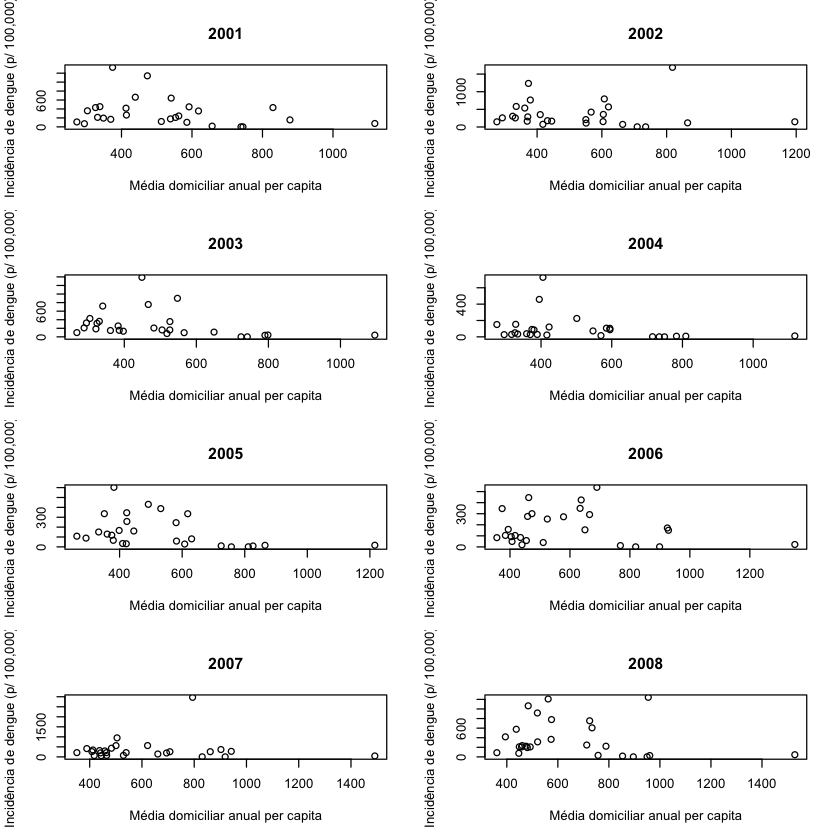

In [4]:
layout(matrix(c(1,2,3,4,5,6,7,8), 4, 2, byrow = TRUE))
xlab.str = "Média domiciliar anual per capita"

for (i in 1:length(years.under.analysis)) {
    year = as.character(years.under.analysis[i])
    noW(plot(datasus.csv[,year], dengue.subset[,year], ylab="Incidência de dengue (p/ 100,000)", 
        xlab=xlab.str, main = year))
}

Não parece haver, visualmente, uma associação entre as variáveis, visto que independente do aumento da renda não se observa um padrão de aumento ou queda na taxa de incidência de dengue. Na verdade, pode-se ver que muitos estados com maior renda apresentam taxas bastante elevadas de dengue, o que vai contra uma hipótese bastante razoável de que estados "mais ricos" teriam menos casos de dengue. A fim de reassegurar esta conclusão, apresentam-se abaixo as correlações destas variáveis, por ano:

In [15]:
a <- datasus.csv[,2:ncol(datasus.csv)]
b <- dengue.subset[,1:ncol(dengue.subset)]
inter.cor = diag(cor(a, b))
printf('Média da correlação: %f', mean(inter.cor))
inter.cor

[1] "Média da correlação: -0.192377"


2001       2002       2003       2004       2005       2006       2007 
-0.2684784 -0.0156217 -0.3055220 -0.2667358 -0.3943191 -0.1495691  0.0361059 
      2008 
-0.1748744

,2001,2002,2003,2004,2005,2006,2007,2008
1,513.04,551.3,482.18,501.13,531.55,578.56,539.47,573.7
2,618.51,603.7,504.81,405.38,422.79,510.85,529.08,520.71
3,439.19,417.79,397.31,389.29,421.36,440.01,444.1,475.56
4,473.38,409.74,448.92,328.37,381.98,524.53,464.19,562.05
5,413.99,431.97,361.52,380.09,375.02,404.09,441.66,457.6
6,540.96,445.1,466.59,395.07,491.78,473.23,500.64,480.35
7,412.81,369.52,385.99,422.79,423.24,462.42,504.69,575.05
8,273.38,275.78,268.36,295.77,263.43,356.22,350.87,360.99
9,303.32,324.55,294.96,316.87,333.13,394.2,437.89,446.98
10,338.77,332.68,304.49,326.23,351.24,373.8,388.86,436.99


,2001,2002,2003,2004,2005,2006,2007,2008
Rondonia,120.06,109.44,206.68,224.87,387.46,272.33,212.64,365.9
Acre,354.98,151.97,161.51,727.66,345.53,39.61,75.06,313.64
Amazonas,662.66,75.8,132.36,29.02,31.49,19.33,61.37,222.77
Roraima,1140.53,351.14,1390.14,153.2,602.84,251.89,212.15,1207.9
Para,264.13,178.29,148.35,84.63,118.35,92.46,199.51,207.57
Amapa,642.17,166.11,755.37,458,430.55,300.3,562,194.89
Tocantins,417.55,163.88,153.23,120.26,257.17,445.8,949.38,778.75
Maranhao,109.7,146.49,99.75,27.02,108.3,83.61,213.56,87.94
Piaui,359.11,304.88,325.1,29.39,150.65,158.35,315.19,74.81
Ceara,451.71,257.04,429.55,50.08,335.9,346.33,414.13,576.56


,2001,2002,2003,2004,2005,2006,2007,2008
2001,-0.26847841,-0.03620681,-0.29352913,-0.03258815,-0.27550702,-0.13062461,-0.02677462,-0.18174851
2002,-0.32419626,-0.01562170,-0.33485360,-0.09123985,-0.33614984,-0.14096666,-0.02167173,-0.20577839
2003,-0.30453805,-0.03939051,-0.30552198,-0.12953306,-0.33353793,-0.15885062,-0.03534057,-0.16813633
2004,-0.391386194,0.006890661,-0.388738146,-0.266735770,-0.438247976,-0.135442183,-0.029903093,-0.190218588
2005,-0.317308606,-0.004492921,-0.325163908,-0.231545737,-0.394319135,-0.119465669,-0.026313702,-0.189644496
2006,-0.318164128,-0.003558808,-0.314585730,-0.229821056,-0.383004224,-0.149569089,-0.024047173,-0.169371131
2007,-0.33118356,-0.03572055,-0.34590120,-0.23400485,-0.41361032,-0.12655433,0.03610590,-0.22161604
2008,-0.314117930,-0.017684762,-0.306147613,-0.265665146,-0.372447465,-0.103383234,-0.001724909,-0.174874386


Para um valor tão baixo, de aproximadamente `-0.20`, pode-se concluir que as variáveis de renda e incidência da dengue de fato não apresentam uma associação, reforçando a conclusão extraída a partir dos gráficos.

### Análise Antiga - Microdados "crus" da PNADc

Primeiramente, execute o código abaixo a fim de produzir os resultados utilizados para gerar e exibir os gráficos.

In [6]:
# Basic setup
year.periods = list(c(2001:2003), c(2004:2008))
states = c("Rondonia", "Acre", "Amazonas", "Roraima", "Para",
               "Amapa", "Tocantins", "Maranhao", "Piaui", "Ceara",
               "Rio Grande do Norte", "Paraiba", "Pernambuco", "Alagoas",
               "Sergipe", "Bahia", "Minas Gerais", "Espirito Santo",
               "Rio de Janeiro", "Sao Paulo", "Parana", "Santa Catarina",
               "Rio Grande do Sul", "Mato Grosso do Sul", "Mato Grosso",
               "Goias", "Distrito Federal");
for (years in year.periods) {
    # Ignora os cálculos de renda caso já exista um arquivo com tais resultados
    period.begin = years[1]
    period.end = years[length(years)]
    results.data.file = paste(base.dir, '/results_', period.begin, '_', period.end,'.RData', sep='');
    
    if (!file.exists(results.data.file)) {
        results = data.frame(row.names = states) # data frame com renda média e taxa de incidência de dengue por UF

        for (year in years) {
          file.header <- paste(base.dir, year, '', sep='/')
          file.path   <- paste(file.header, 'Dados/DOM', year, '.txt', sep='')

          print(paste("Processando os dados para o ano ", year, "...", sep=''))

          if(year >= 2007) {
            # Para as PNADc de 2007 e 2008 já são disponibilizados data frames com os dados
            dic <- load.rdata.into.obj(paste(file.header, '/Leitura em R/dicPNAD',
                                             year, '.RData', sep=''))
            pnad.data <- read.fwf(file.path, widths = dic$tamanho)
            # rename the columns to the standard spec
            names(pnad.data) <- dic$cod
          }
          else {
            # Para os demais anos há um arquivo do tipo SAS na sub-pasta `Input` de cada
            # ano que contém a descrição das variáveis do dataset. Basta então ler o dataset
            # diretamente usando a biblioteca de SAS carregada no Setup.
            pnad.data <- noW(read.SAScii(file.path, 
                                     paste(file.header, 'Input/input dom', year, '.txt', sep=''),
                                     intervals.to.print = 10000, buffersize = 10000))
          }

          # Agregação dos dados ao df `results` 
          # Calcula a renda per cápita segundo UF, ignorando _missing data_

          # Antes de 2004 a renda per cápita por domício segundo UF não é reportada diretamente
          # no dataset. Logo, a renda mensal domiciliar é usada.
          income.code = 'V4621'
          if (year < 2004) {
            income.code = 'V4614'
          }

          # Algumas entidades apresentam uma renda per capita ou mensal muito elevada,
          #   o que acaba ocasionando uma média bastante desviada para a direita (right skew).
          #   Sendo assim, valores extremamente elevados são ignorados por distorcerem os resultados.
          valid.data = pnad.data[income.code] < 900000000000 
          avg.income = tapply(pnad.data[income.code][valid.data], 
                              pnad.data$UF[valid.data], mean, na.rm=TRUE)
          names(avg.income) <- states

          results <- cbind(results, avg.income)

          # Remove as variáveis usadas para o ano atual
          remove(pnad.data);
          gc();
        }

        # Renomeia as colunas segundo o formato `<year>.income`.
        names(results) = lapply(years, paste, '.income', sep='')
        save(results, file=results.data.file)
    } else {
        results = load.rdata.into.obj(results.data.file)
    }

    years.under.analysis = years
    names(results) = years.under.analysis

    # now, read the dengue incidence rate dataset
    dengue = read.csv(paste(base.dir, '/dengueUF.csv', sep=''), dec=",", na.strings = '-')
    dengue.cols = sapply('X', paste, years.under.analysis, sep='', USE.NAMES = FALSE)
    dengue.subset = dengue[1:27, dengue.cols]

    dengue.new.cols = vector(mode="character", length =length(dengue.cols))
    for (i in 1:length(names(dengue.subset))) {
      dengue.new.cols[i] = substr(names(dengue.subset)[i], 2, 5)
    }
    names(dengue.subset) = dengue.new.cols
    row.names(dengue.subset) = dengue$UF[1:27]

    # Calculate the cross-UF correlation. This tells us whether higher income states
    # have a relatively lower dengue incidence rate when compared to others
    cross.state.cor = diag(cor(results, dengue.subset))
    names(cross.state.cor) = years.under.analysis

    # Calculate the intra-UF correlation. This tells us whether higher income in a
    # state is associated with a lower dengue incidence rate **within** that state.
    # In this case, the state is evaluated on its own.
    A <- as.matrix(results)
    B <- as.matrix(dengue.subset)
    intra.state.cor = sapply(seq.int(dim(A)[1]), function(i) cor(A[i,], B[i,]))
    names(intra.state.cor) = dengue$UF[1:27]
}

A análise foi feita com base nos microdados do PNAD disponíveis na página do IBGE [1] e nos dados de incidência da dengue disponíveis no GitHub do curso. Devido a ausência de dados para os anos de 1990 a 2000 no site do IBGE, a análise que segue se limitou aos anos de 2001 a 2008. Além disso, em razão da ausência da variável de renda anual per capita até o ano de 2003, os anos de 2001 a 2003 foram analisados a parte, sendo utilizada a variável de renda mensal domiciliar para efeitos de noção de renda. É importante destacar que nestes anos certas regiões desfavorecidas não foram abrangidas pelo PNAD. [2]

Um outro problema a ser apontado é o elevado valor encontrado para as rendas, em ambos os casos. Certamente, há o peso de outliers que levam a distribuição de renda média a ser _right-skewed_, mas creio haver um problema no pré-processamento dos dados. Em todo caso, os valores calculados estão com as proporções relativas esperadas, similares a fontes confiáveis que publicam tabelas com os dados de renda já processados. [3] Além disto, faltou ser realizado o cálculo de valor presente da renda com base na inflação para ajustá-la a um ano base. Apesar destes problemas com o pré-processamento dos dados, optei por fazer a análise toda em R por acreditar que este fosse o espírito do exercício.
Em resumo, não foi encontrada, para o período de 2001 a 2008, correlação entre incidência de dengue e renda nas UFs. Abaixo apresenta-se uma análise detalhada.

Para o período de 2004 a 2008 foi calculada uma correlação média de aproximadamente -0,22 entre a renda per capita na UF e incidência de dengue nesta relativa as demais. Para um valor tão baixo, pode-se dizer que as variáveis de renda e incidência da dengue não apresentam correlação. Abaixo pode-se observar os valores para cada anos:

In [7]:
printf("Média da correlação inter-estadual: %f", mean(cross.state.cor))
cross.state.cor

[1] "Média da correlação inter-estadual: -0.217749"


2004         2005         2006         2007         2008 
-0.283522308 -0.396186297 -0.227995158  0.005538225 -0.186577085

Além disso, para ficar clara a visualização deste resultado, pode-se observar os scatterplots por ano, que demonstram a ausência de associação entre as variáveis durante todos os anos sob estudo.

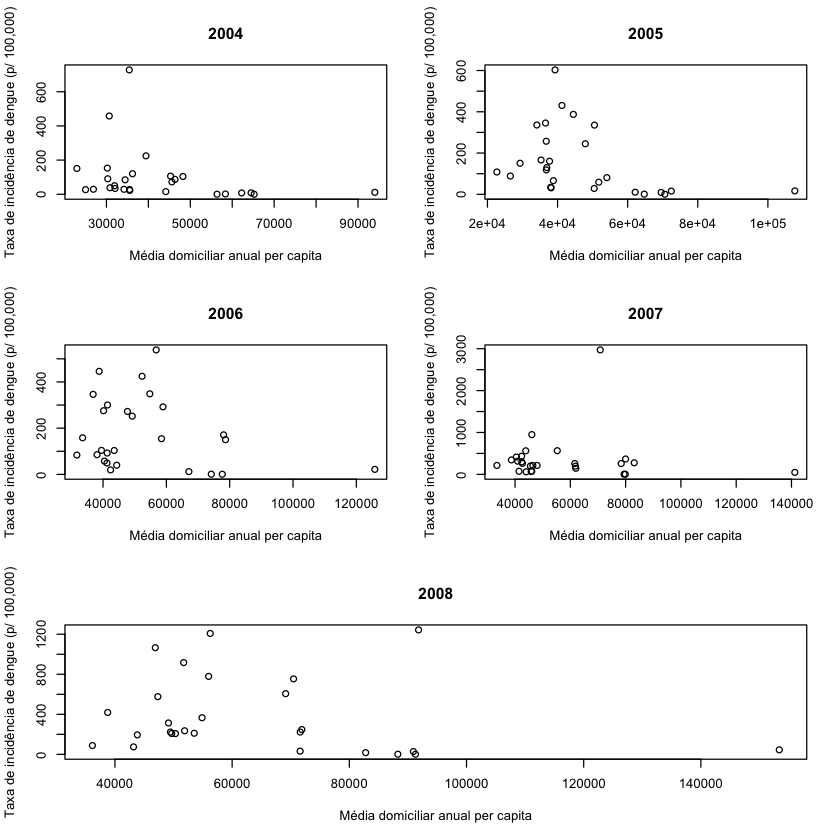

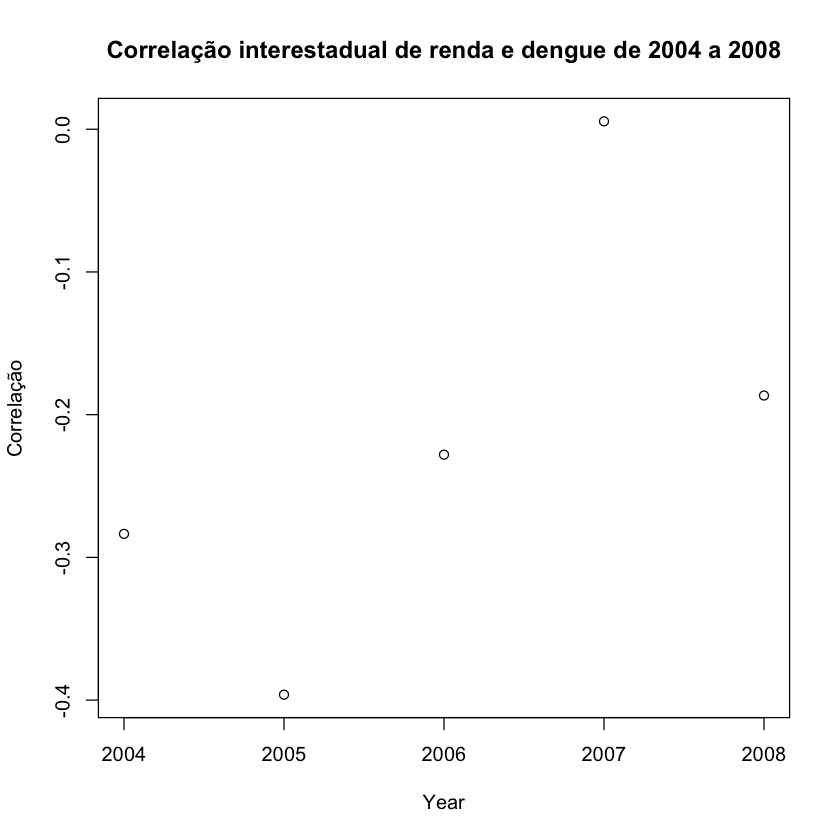

In [8]:
cross.title = paste('Correlação interestadual de renda e dengue de', 
                    years.under.analysis[1], 'a', tail(years.under.analysis, n=1))
intra.title = paste('Correlação intraestadual de renda e dengue de', 
                    years.under.analysis[1], 'a', tail(years.under.analysis, n=1))

layout(matrix(c(1,2,3,4,5,5), 3, 2, byrow = TRUE))
xlab.str = "Média domiciliar anual per capita"


for (i in 1:length(years.under.analysis)) {
    year = as.character(years.under.analysis[i])
    noW(plot(results[,year], dengue.subset[,year], ylab="Taxa de incidência de dengue (p/ 100,000)", 
        xlab=xlab.str, main = year))
}

par(mfrow=c(1,1), par(xpd=T))
noW(plot(cross.state.cor, xlab="Year", ylab="Correlação", xaxt = "n", main=cross.title))
axis(side=1, at=1:length(cross.state.cor), labels=names(cross.state.cor))

Contudo, procurei determinar se obteria um resultado diferente caso analisasse cada UF isoladamente. Afinal, na análise anterior avalia-se o conjunto das UFs por ano, obtendo-se assim um dado que relativiza uma UF as demais; por outro lado, entender o comportamento isolado de cada UF é interessante. O curioso é que, neste caso, observa-se uma correlação positiva, em muitos casos forte, entre renda anual per capita e incidência de dengue. Embora não se possa estabelecer uma relação causal, há uma clara associação entre as variáveis para a maioria das UFs, quando vistas isoladamente:


[1] "Média da correlação intra-estadual: 0.589229"


Rondonia                Acre            Amazonas             Roraima 
          0.4212436          -0.6734611           0.7952080           0.6282788 
               Para               Amapa           Tocantins            Maranhao 
          0.8812786          -0.2519917           0.7995847           0.3797101 
              Piaui               Ceara Rio Grande do Norte             Paraiba 
          0.4270844           0.9000282           0.9502169           0.6898562 
         Pernambuco             Alagoas             Sergipe               Bahia 
          0.6796862           0.5548660           0.8669183           0.6983338 
       Minas Gerais      Espirito Santo      Rio de Janeiro           Sao Paulo 
          0.9444279           0.8788693           0.9200134           0.3779535 
             Parana      Santa Catarina   Rio Grande do Sul  Mato Grosso do Sul 
          0.5005507           0.7715459           0.3891072           0.5552415 
        Mato Grosso               Goias    Distrito Federal 
          0.1427767           0.7408653           0.9409848

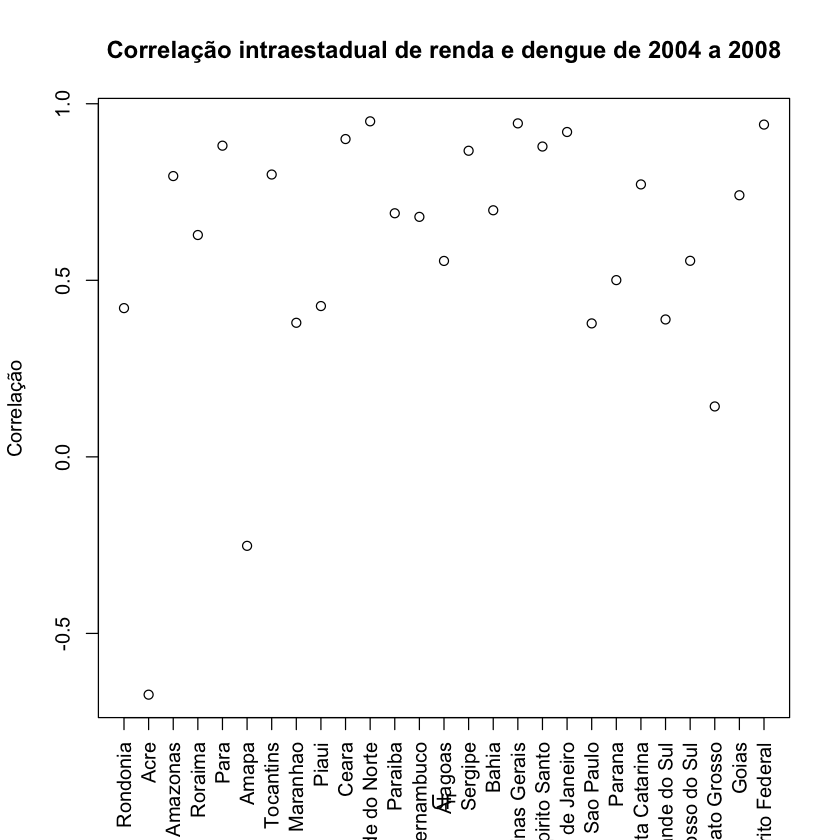

In [9]:
printf("Média da correlação intra-estadual: %f", mean(intra.state.cor))
intra.state.cor

noW(plot(intra.state.cor, xlab="UF", ylab="Correlação", xaxt = "n", main=intra.title))
axis(side=1, at=1:length(intra.state.cor), labels=names(intra.state.cor), las=2)

Isto não é necessariamente contra-intuitivo: uma possível hipótese é a de que um UF mais rico pode empregar mais recursos no combate a doença, mas o crescimento desenfreado urbano e maior produção de resíduos podem levar a um aumento da doença no UF apesar disso. Outra hipótese seria de que, conforme as UF ficaram mais ricas, elas foram capazes de melhor medir casos de incidência de dengue. Novamente, é preciso enfatizar que embora levante tais hipóteses, este estudo não as afirma nem as explora, limitando-se a expor apenas a associação observada entre dengue e renda no caso intra-estadual. 

Além disso, vale destacar os casos do Acre e Amapá: como pode ser observado nos dados acima, ambos apresentam uma correlação negativa entre a renda e incidência de dengue, sendo esta bastante forte no caso do Acre. Esta descoberta poderia motivar um estudo que procure entender a fundo o motivo de tal discrepância.

Rapidamente, façamos uma análise dos anos de 2001-2003. Para estes anos o PNAD não publicou uma variável de renda anual per capita, sendo necessário o uso da variável de renda mensal domiciliar, não ajustada ao número de integrantes por domicílio. No caso geral, encontrou-se uma correlação negativa bem fraca entre as variáveis, podendo-se dizer que elas não são correlacionadas.

[1] "Média da correlação inter-estadual: -0.220389"


2001       2002       2003 
-0.2602540 -0.1670024 -0.2339121

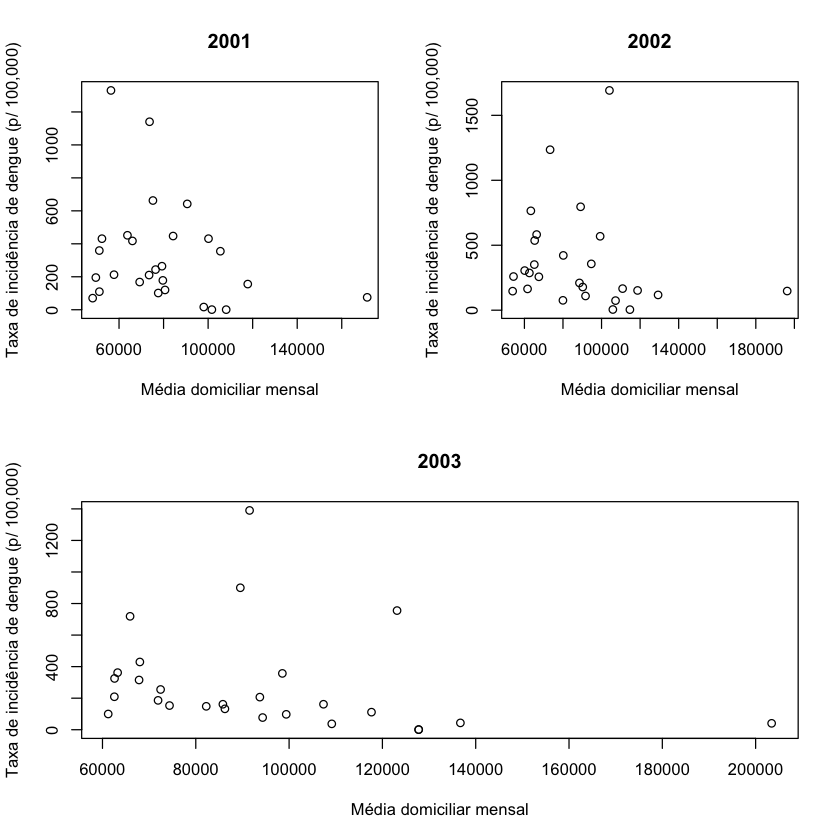

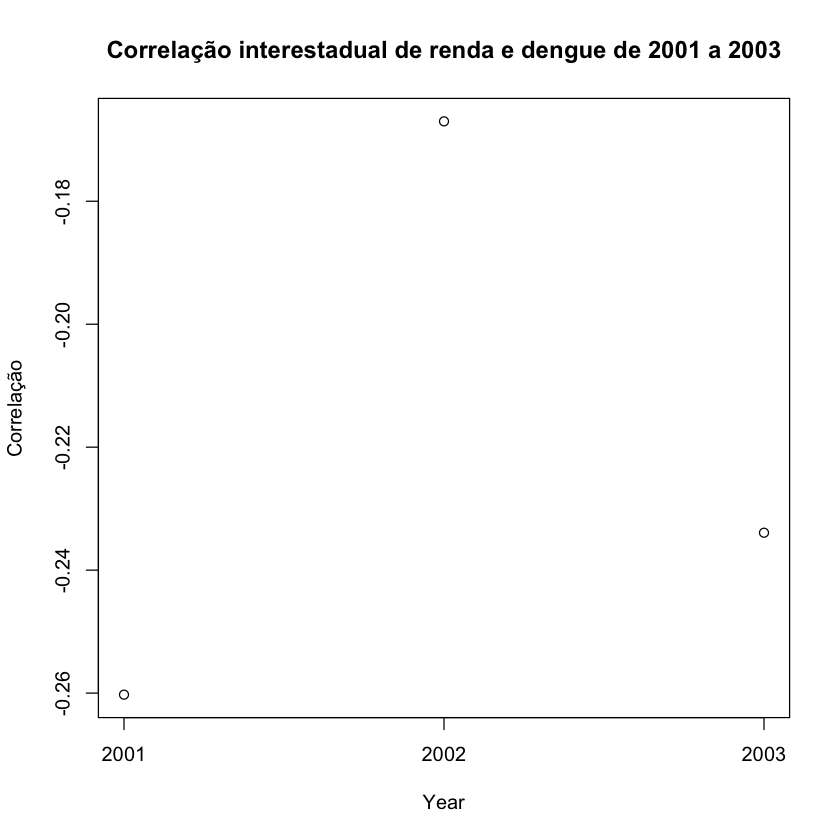

In [10]:
# Bootstrapring das variáveis para 2001->2003 (não o método estatístico)
years.under.analysis = c(2001:2003)
period.begin = years.under.analysis[1]
period.end = years.under.analysis[length(years.under.analysis)]
results.data.file = paste(base.dir, '/results_', period.begin, '_', period.end,'.RData', sep='');
results = load.rdata.into.obj(results.data.file)
names(results) = years.under.analysis

dengue = read.csv(paste(base.dir, '/dengueUF.csv', sep=''), dec=",", na.strings = '-')
dengue.cols = sapply('X', paste, years.under.analysis, sep='', USE.NAMES = FALSE)
dengue.subset = dengue[1:27, dengue.cols]

dengue.new.cols = vector(mode="character", length =length(dengue.cols))
for (i in 1:length(names(dengue.subset))) {
    dengue.new.cols[i] = substr(names(dengue.subset)[i], 2, 5)
}
names(dengue.subset) = dengue.new.cols
row.names(dengue.subset) = dengue$UF[1:27]

cross.state.cor = diag(cor(results, dengue.subset))
names(cross.state.cor) = years.under.analysis

A <- as.matrix(results)
B <- as.matrix(dengue.subset)
intra.state.cor = sapply(seq.int(dim(A)[1]), function(i) cor(A[i,], B[i,]))
names(intra.state.cor) = dengue$UF[1:27]
    
# Código relevante
printf("Média da correlação inter-estadual: %f", mean(cross.state.cor))
cross.state.cor
    
cross.title = paste('Correlação interestadual de renda e dengue de', 
                    years.under.analysis[1], 'a', tail(years.under.analysis, n=1))
intra.title = paste('Correlação intraestadual de renda e dengue de', 
                    years.under.analysis[1], 'a', tail(years.under.analysis, n=1))

layout(matrix(c(1,2,3,3), 2, 2, byrow = TRUE))
xlab.str = "Média domiciliar mensal"

for (i in 1:length(years.under.analysis)) {
    year = as.character(years.under.analysis[i])
    noW(plot(results[,year], dengue.subset[,year], ylab="Taxa de incidência de dengue (p/ 100,000)", 
        xlab=xlab.str, main = year))
}

par(mfrow=c(1,1), par(xpd=T))
noW(plot(cross.state.cor, xlab="Year", ylab="Correlação", xaxt = "n", main=cross.title))
axis(side=1, at=1:length(cross.state.cor), labels=names(cross.state.cor))

Para o caso intra-estado, nota-se uma significativa diferença frente ao período de 2004 a 2008, analisado anteriormente. Há uma altíssima variabilidade entre os resultados por estado, de modo que a média é praticamente nula. 

[1] "Média da correlação intra-estadual: -0.010882"


Rondonia                Acre            Amazonas             Roraima 
         0.53897683         -0.64177479         -0.77136218          0.88164153 
               Para               Amapa           Tocantins            Maranhao 
        -0.51043588          0.03943631         -0.21130980         -0.44561919 
              Piaui               Ceara Rio Grande do Norte             Paraiba 
        -0.83499563         -0.49343841         -0.98069389          0.26468351 
         Pernambuco             Alagoas             Sergipe               Bahia 
         0.77546649          0.65012985          0.70183142          0.61126686 
       Minas Gerais      Espirito Santo      Rio de Janeiro           Sao Paulo 
        -0.64045087          0.99269937         -0.29696217         -0.95299183 
             Parana      Santa Catarina   Rio Grande do Sul  Mato Grosso do Sul 
         0.98805775         -0.31632468         -0.20753867         -0.27496789 
        Mato Grosso               Goias    Distrito Federal 
         0.98508605         -0.12911405         -0.01509814

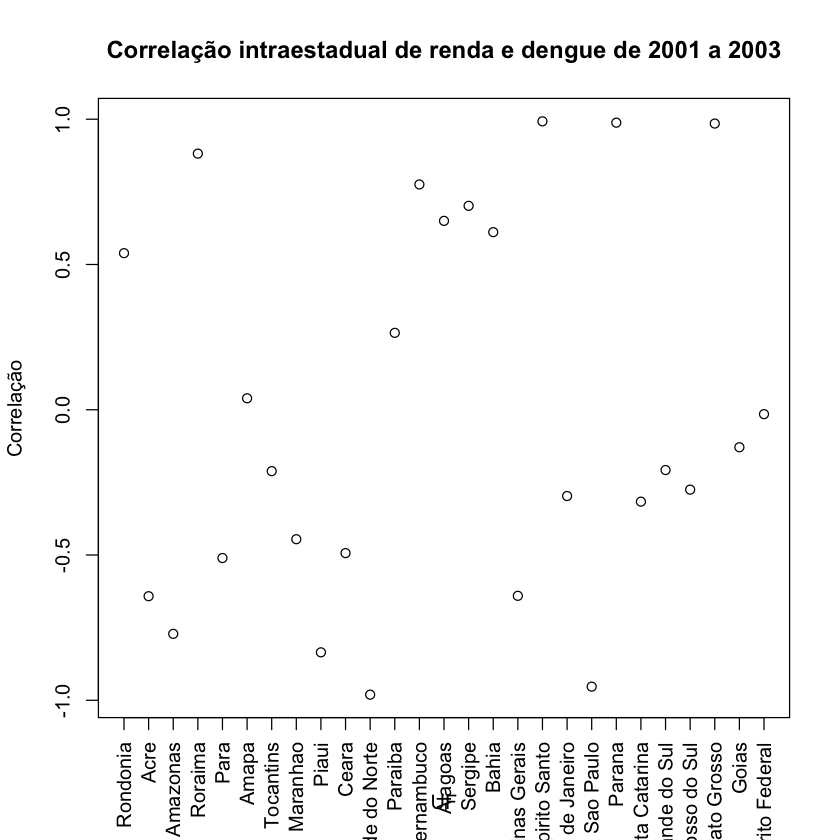

In [11]:
printf("Média da correlação intra-estadual: %f", mean(intra.state.cor))
intra.state.cor

noW(plot(intra.state.cor, xlab="UF", ylab="Correlação", xaxt = "n", main=intra.title))
axis(side=1, at=1:length(intra.state.cor), labels=names(intra.state.cor), las=2)

## Referências

[1] http://www.ibge.gov.br/home/estatistica/populacao/trabalhoerendimento/pnad2014/microdados.shtm

[2] http://www.ibge.gov.br/home/estatistica/populacao/trabalhoerendimento/pnad2013/default_sintese.shtm

[3] http://tabnet.datasus.gov.br/cgi/tabnet.exe?idb2012/b08c.def